In [56]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
dev = qml.device('default.qubit', wires=3)

In [58]:
# two qubit case
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.RY(np.pi / 4, wires=1)
    qml.RY(np.pi / 4, wires=2)
    qml.RX(np.pi / 4, wires=0)
    qml.CNOT(wires=[0, 1])
    qml.Rot(*angles, wires=0)
    qml.CNOT(wires=[1, 2])
    qml.Rot(*angles, wires=1)

In [59]:
def utheta(w, wires, **kwargs):
    qml.Hadamard(wires=wires[0])
    qml.RX(w[0], wires=wires[0])
    qml.RX(w[1], wires=wires[1])
    qml.RY(w[2], wires=wires[0])
    qml.RY(w[3], wires=wires[1])
    qml.RZ(w[4], wires=wires[0])
    qml.RZ(w[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RX(w[6], wires=wires[0])
    qml.RY(w[7], wires=wires[0])
    qml.RZ(w[8], wires=wires[0])
    qml.RX(w[9], wires=wires[1])
    qml.RY(w[10], wires=wires[1])
    qml.RZ(w[11], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RX(w[12], wires=wires[0])
    qml.RY(w[13], wires=wires[0])
    qml.RZ(w[14], wires=wires[0])
    qml.RX(w[15], wires=wires[1])
    qml.RY(w[16], wires=wires[1])
    qml.RZ(w[17], wires=wires[1])

In [60]:
@qml.qnode(dev, interface="tf")
def qpca(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, [0, 1])
    z0 = qml.expval(qml.PauliZ(0))
    z1 = qml.expval(qml.PauliZ(1))
    return z0, z1

In [61]:
def pcaloss(angles, theta_weights, **kwargs):
    z0, z1 = qpca(angles, theta_weights)
    return 1/12 * ((z0 + 1) + 2 * (z1 + 1))

In [62]:
angles = [np.pi / 6, np.pi / 2, np.pi / 7]

np.random.seed(0)
eps = 1e-2
init_theta_weights = np.array([0] + [0] * 17) + \
                   np.random.normal(scale=eps, size=(18,))
theta_weights = tf.Variable(init_theta_weights)

opt = tf.keras.optimizers.SGD(4)

In [63]:
@qml.qnode(dev, interface="tf")
def show_real(angles, **kwargs):
    real(angles)
    return qml.density_matrix([0, 1])
real_matrix = show_real(angles).numpy()
U, S, V = np.linalg.svd(real_matrix)
print(S)
#minloss = np.sum(S * np.arange(3, -1, -1))/12*2
minloss = np.sum(S * np.arange(0, 4, 1))/6
print(minloss)

[8.53553391e-01 1.46446609e-01 1.11664317e-16 1.38436866e-17]
0.02440776823445441


Step 0: cost = 0.08731147138065784
Step 5: cost = 0.04493122000596672
Step 10: cost = 0.04255865754882988
Step 15: cost = 0.040288413286132176
Step 20: cost = 0.03811459514407403
Step 25: cost = 0.03600369357696277
Step 30: cost = 0.03394416780620033
Step 35: cost = 0.0320126895398543
Step 40: cost = 0.0302939217974953
Step 45: cost = 0.028833344792607102
Step 50: cost = 0.027644865999728048
Step 55: cost = 0.026719194873341713
Step 60: cost = 0.02602661992005792
Step 65: cost = 0.02552497194448855
Step 70: cost = 0.02517032596009764
Step 75: cost = 0.024924000221199727
Step 80: cost = 0.024755131035119317
Step 85: cost = 0.02464048823485034
Step 90: cost = 0.02456322551031001
Step 95: cost = 0.024511432431586766
Step 100: cost = 0.02447684222279651
Step 105: cost = 0.024453796339798457
Step 110: cost = 0.024438461637746246
Step 115: cost = 0.024428261745800473
Step 120: cost = 0.024421474672591405
Step 125: cost = 0.024416954011789217
Step 130: cost = 0.02441393843668387
Step 135: cos

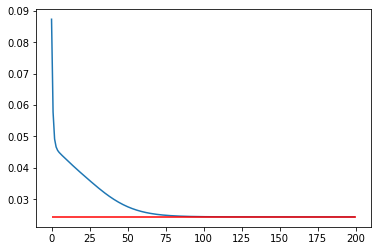

In [64]:
cost = lambda: pcaloss(angles, theta_weights)
n_step = 200
cost_list = []
for step in range(n_step):
    opt.minimize(cost, theta_weights)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        print("Step {}: cost = {}".format(step, cost_val))
plt.plot(np.arange(n_step), cost_list)
plt.hlines(minloss, 0, n_step, color='r')
plt.show()

In [65]:
@qml.qnode(dev, interface="tf")
def show_real_diag(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, [0, 1])
    return qml.density_matrix([0, 1])

[8.53553391e-01 1.46446609e-01 1.11664317e-16 1.38436866e-17]
[8.53553385e-01 1.46446453e-01 1.33851897e-07 2.81709020e-08]


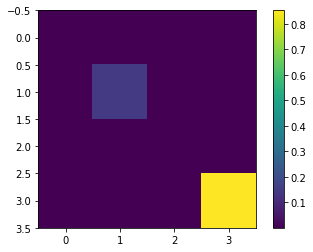

In [66]:
print(S)
print(-np.sort(-np.abs(np.diag(show_real_diag(angles, theta_weights).numpy()))))
plt.imshow(np.abs(show_real_diag(angles, theta_weights).numpy()))
plt.colorbar()
plt.show()